In [1]:
import tjl_dense_numpy_tensor
import numpy as np
import matplotlib.pyplot as plt

In [57]:
path = np.random.rand(100, 3)

In [58]:
N = 4

In [59]:
sig_tensor = tjl_dense_numpy_tensor.stream2sigtensor(path, N)

In [62]:
sig_tensor_plus1 = tjl_dense_numpy_tensor.stream2sigtensor(path, N+1)

In [63]:
sig_tensor_logexp = tjl_dense_numpy_tensor.tensor_exp(tjl_dense_numpy_tensor.tensor_log(sig_tensor, N+1), N+1)

In [64]:
diff = np.abs(sig_tensor_plus1 - sig_tensor_logexp)

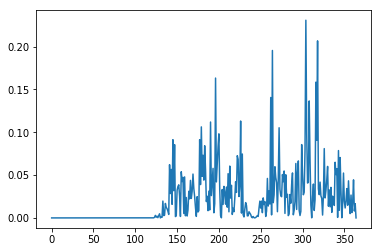

In [65]:
plt.plot(diff)
plt.show()